# League of Legends Support Vision Score Analysis

**Name(s)**: Derrick Dollesin

**Website Link**: https://derrickdollesin.github.io/League-of-Legends-Data-Project/ 

In [319]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from pathlib import Path
from sklearn.utils import resample
from scipy.stats import ttest_ind, ks_2samp, stats

# from dsc80_utils import * # Feel free to uncomment and use this.

In [4]:
dirname = Path('data') / '2022_LoL_esports_match_data_from_OraclesElixir.csv'
raw_data = pd.read_csv(dirname, low_memory=False)

## Step 1: Introduction


League of Legends (LoL) is a multiplayer online battle arena (MOBA) game developed and published by Riot Games. Two teams of five players compete to defend their base while demolishing the Nexus of the opposing team. Players take control of a variety of characters known as "champions", each with unique playstyles and powers, to achieve objectives such as defeating rival champions, destroying turrets, and capturing neutral creatures.

The professional data set that we will be working with was created by Oracle's Elixir. Match data from professional LOL esports gaming matches throughout 2022 is recorded in the dataset. By collecting significant gaming data and outcomes from a selection of LOL matches, this dataset offers a multitude of information for understanding player behavior, team dynamics, and match outcomes. Among the features it provides are in-game statistics, team strategies, individual player performance, and overall match dynamics.

In League of Legends (LOL), the "***visionscore***" has to do with "wards" placed by players around the map. These "wards" grant vision to areas of the map otherwise hidden to player view. Controlling more vision of the map allows for players to track enemy movement and obtain positional advantages against their enemies.

The central question we are interested in is: ***How much of an impact does the visionscore statline have on the other gaming metrics in the dataset?***




## Step 2: Data Cleaning and Exploratory Data Analysis

In [328]:
lck_data = raw_data[raw_data['league'] == 'LCK']
lck_data = lck_data.assign(date=pd.to_datetime(lck_data['date']))
lck_data = lck_data.query('datacompleteness == "complete"')
lck_data = lck_data.drop(columns='url')
support_data = lck_data[lck_data['position'] == 'sup']
support_data = support_data.assign(is_25=(support_data['gamelength'] >= 60 * 25))

support_data.head()

,gameid,datacompleteness,league,year,split,playoffs,date,game,patch,participantid,...,golddiffat25,xpdiffat25,csdiffat25,killsat25,assistsat25,deathsat25,opp_killsat25,opp_assistsat25,opp_deathsat25,is_25
1444,ESPORTSTMNT01_2700815,complete,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,5,...,2094.0,1086.0,10.0,1.0,3.0,0.0,0.0,2.0,1.0,True
1449,ESPORTSTMNT01_2700815,complete,LCK,2022,Spring,0,2022-01-12 06:20:03,1,12.01,10,...,-2094.0,-1086.0,-10.0,0.0,2.0,1.0,1.0,3.0,0.0,True
1456,ESPORTSTMNT01_2690695,complete,LCK,2022,Spring,0,2022-01-12 09:02:13,2,12.01,5,...,487.0,22.0,-1.0,1.0,1.0,1.0,0.0,1.0,0.0,True
1461,ESPORTSTMNT01_2690695,complete,LCK,2022,Spring,0,2022-01-12 09:02:13,2,12.01,10,...,-487.0,-22.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,True
1480,ESPORTSTMNT01_2690705,complete,LCK,2022,Spring,0,2022-01-12 10:07:10,1,12.01,5,...,261.0,-409.0,-10.0,1.0,4.0,2.0,1.0,1.0,2.0,True


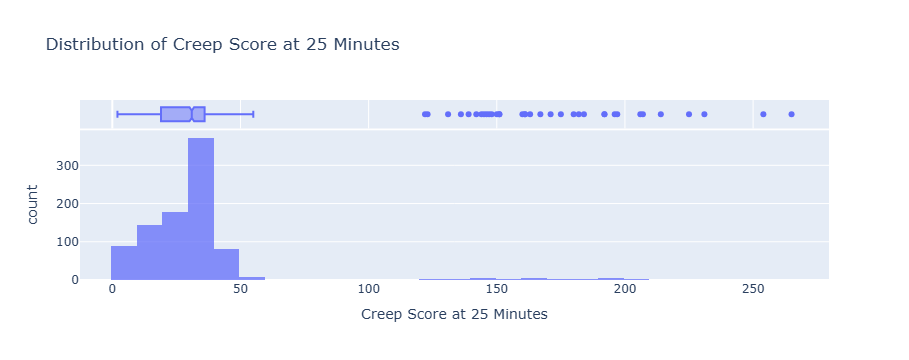

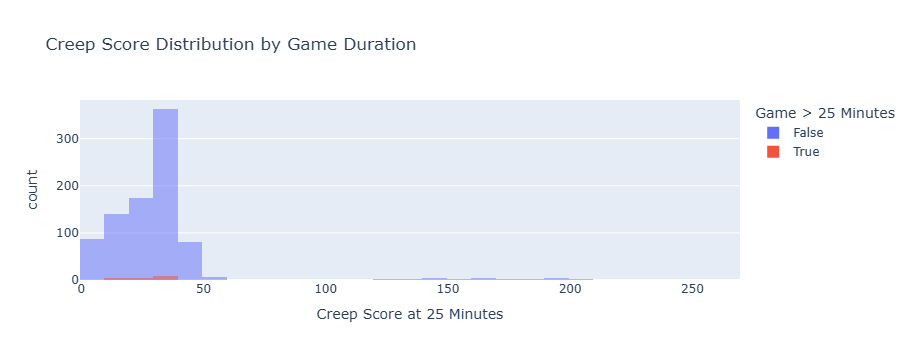

In [348]:
fig_1 = px.histogram(
    df,
    x='csat25',
    nbins=30,
    title='Distribution of Creep Score at 25 Minutes',
    labels={'csat25': 'Creep Score at 25 Minutes'},
    marginal='box',  # Adds a box plot above the histogram
    opacity=0.75
)

fig_2 = px.histogram(
    df,
    x='csat25',
    color='is_25',
    barmode='overlay',
    nbins=30,
    labels={'csat25': 'Creep Score at 25 Minutes', 'is_25': 'Game > 25 Minutes'},
    title='Creep Score Distribution by Game Duration',
    opacity=0.5
)

fig_1.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_1.html', include_plotlyjs='cdn')
fig_2.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_2.html', include_plotlyjs='cdn')



fig_1.show()
fig_2.show()

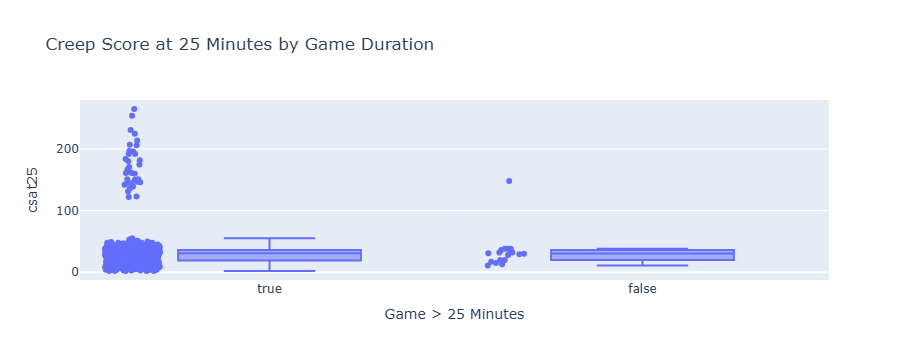

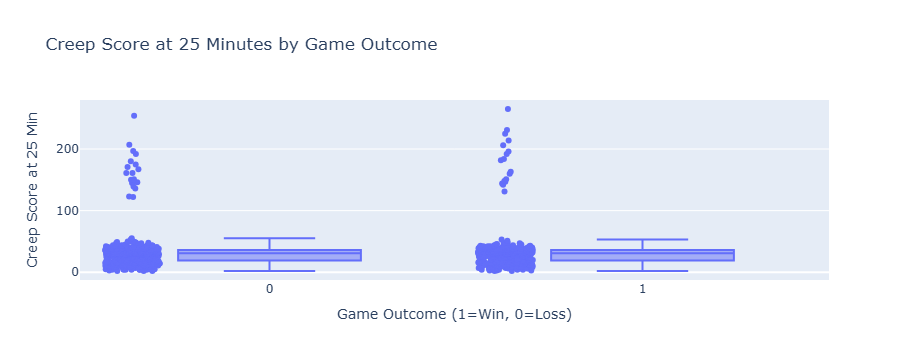

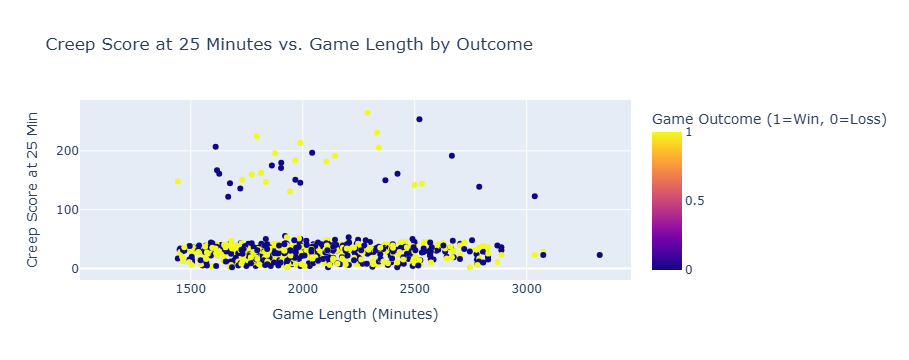

In [349]:
fig_1 = px.box(
    support_data,
    x='is_25',
    y='csat25',
    labels={'is_25': 'Game > 25 Minutes', 'csat250': 'Creep Score at 25 Min'},
    title='Creep Score at 25 Minutes by Game Duration',
    points='all'
)

fig_2 = px.box(
    support_data,
    x='result',  
    y='csat25',  
    labels={'result': 'Game Outcome (1=Win, 0=Loss)', 'csat25': 'Creep Score at 25 Min'},
    title='Creep Score at 25 Minutes by Game Outcome',
    points="all", 
)

fig_3 = px.scatter(
    support_data,
    x='gamelength',  
    y='csat25', 
    color='result', 
    labels={
        'gamelength': 'Game Length (Minutes)',
        'csat25': 'Creep Score at 25 Min',
        'result': 'Game Outcome (1=Win, 0=Loss)'
    },
    title='Creep Score at 25 Minutes vs. Game Length by Outcome',
    hover_data=['is_25'] 
)

fig_1.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_3.html', include_plotlyjs='cdn')
fig_2.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_4.html', include_plotlyjs='cdn')
fig_3.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_5.html', include_plotlyjs='cdn')

fig_1.show()
fig_2.show()
fig_3.show()

In [331]:
# Group by 'is_25' and compute aggregate statistics for 'csat25'
grouped_is_25 = support_data.groupby('is_25')['csat25'].agg(['mean', 'median', 'std', 'count'])
grouped_is_25

,mean,median,std,count
is_25,,,,
False,33.888889,30.5,29.856301,18
True,32.826577,31.0,30.992695,888


In [332]:
# Group by 'wins' and compute aggregate statistics for 'csat25'
grouped_wins = support_data.groupby('result')['csat25'].agg(['mean', 'median', 'std', 'count'])
grouped_wins

,mean,median,std,count
result,,,,
0,32.807947,31.0,29.845409,453
1,32.887417,31.0,32.059101,453


## Step 3: Assessment of Missingness

In [333]:
'''
I believe csat25 missingness is NMAR because missing values are related to gamelength.

Null: The missingness in csat25 is independent of gamelength.
Alt: The missingness in csat25 depends on gamelength.
'''

support_data = support_data.assign(missing_csat25=support_data['csat25'].isna())

observed_diff = abs(missing_data.mean() - non_missing_data.mean())

n_permutations = 1_000

simulated_diffs = []

for _ in range(n_permutations):
    shuffled = np.random.permutation(support_data['missing_csat25'])
    
    shuffled_missing_data = support_data[shuffled == True]['gamelength']
    shuffled_non_missing_data = support_data[shuffled == False]['gamelength']
    
    simulated_diff = abs(shuffled_missing_data.mean() - shuffled_non_missing_data.mean())

    simulated_diffs.append(simulated_diff)

simulated_diffs = np.array(simulated_diffs)

p_value = np.mean(simulated_diffs >= observed_diff)

print(f'Observed Diff in Means: {observed_diff}\nP-value: {p_value}')

print('Since p-value is less than 0.05, the decision is to reject the null in favor of the alternate hypothesis. Therefore, I conclude that the missingness is NMAR.')

Observed Diff in Means: 729.3557237464522
P-value: 0.0
Since p-value is less than 0.05, the decision is to reject the null in favor of the alternate hypothesis. Therefore, I conclude that the missingness is NMAR.


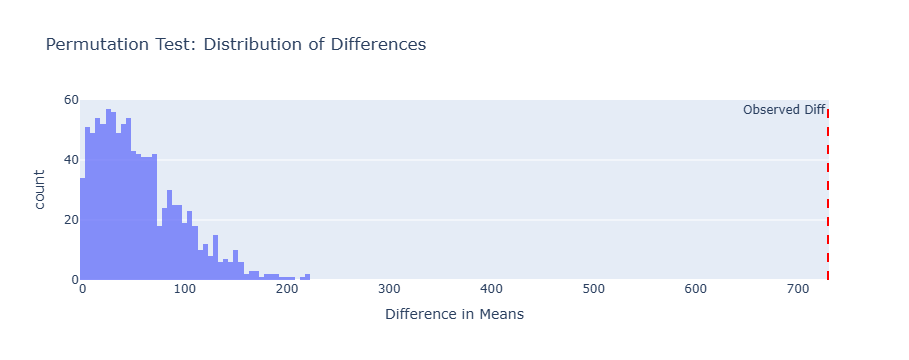

In [350]:
fig = px.histogram(
    x=simulated_diffs,
    nbins=50,
    title='Permutation Test: Distribution of Differences',
    labels={'x': 'Difference in Means'},
    opacity=0.75
)

fig.add_vline(x=observed_diff, line_color='red', line_dash='dash', annotation_text='Observed Diff', annotation_position='top left')
fig.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_6.html', include_plotlyjs='cdn')

fig.show()

## Step 4: Hypothesis Testing

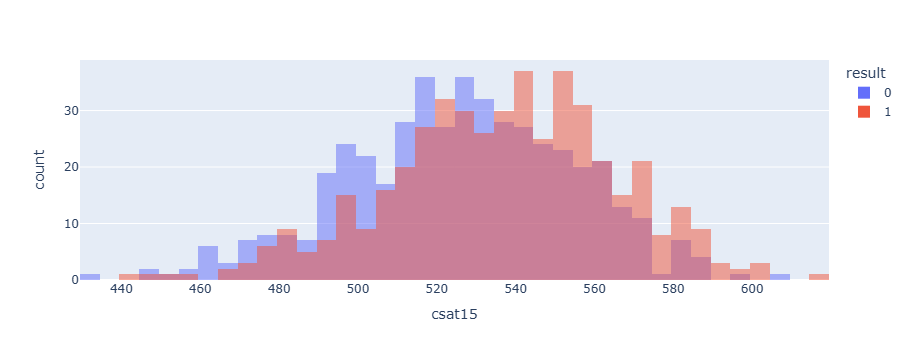

T-statistic: 5.801570957462054, P-value: 8.995682300418895e-09


'\nSince the p-value is < 0.05 the decision is to reject the null in favor of the alternate hypothesis. \n'

In [351]:
"""
Null Hypothesis : Higher csat15 score does not result in a win.
Alternative Hypothesis : Higher csat15 score results in a win.
"""

# only team data
team_data = lck_data.query('position == "team"').reset_index(drop=True)

team_data.groupby('gameid')['csat15'].max()
team_data['result']

fig = px.histogram(team_data, x='csat15', color='result', barmode='overlay')
fig.show()

loss_scores = team_data[team_data['result'] == 0]['csat15']
win_scores = team_data[team_data['result'] == 1]['csat15']

t_stat, p_value = ttest_ind(win_scores, loss_scores, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

fig.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_7.html', include_plotlyjs='cdn')

"""
Since the p-value is < 0.05 the decision is to reject the null in favor of the alternate hypothesis. 
"""


## Step 5: Framing a Prediction Problem

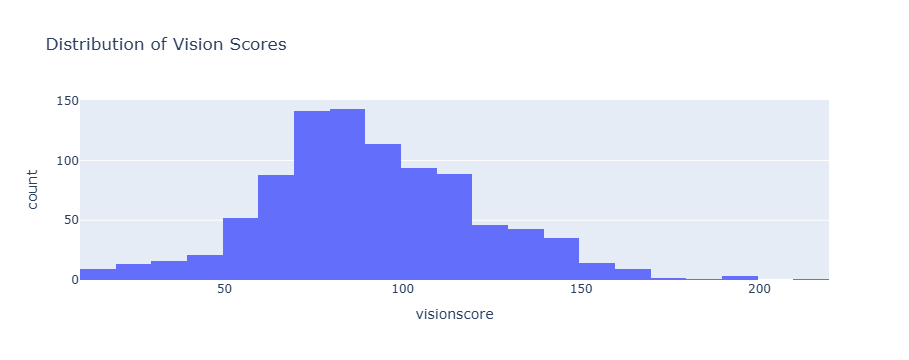

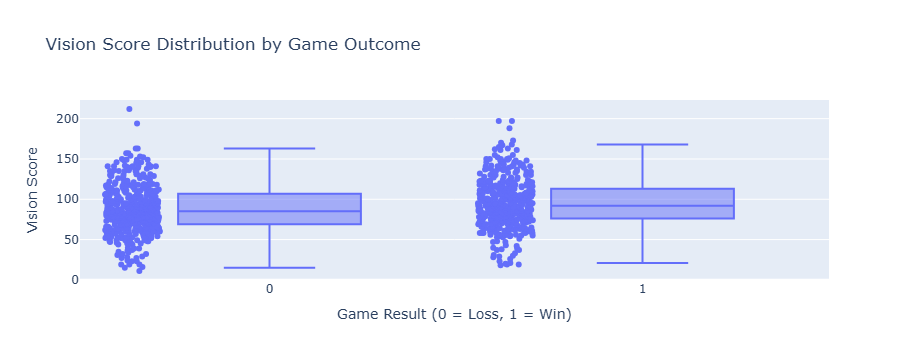

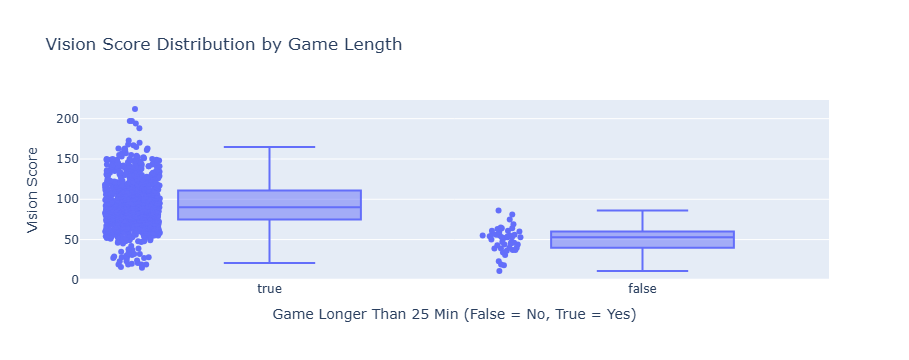

In [353]:
# Can vision score 

any_missing = support_data['visionscore'].isna().sum() != 0

"""
What will a supports vision score be at the end of the game?
"""

fig1 = px.histogram(support_data, x="visionscore", nbins=30, title="Distribution of Vision Scores")
fig1.show()

fig2 = px.box(support_data, x="result", y="visionscore", points="all", 
             labels={"result": "Game Result (0 = Loss, 1 = Win)", "visionscore": "Vision Score"},
             title="Vision Score Distribution by Game Outcome")
fig2.show()

fig3 = px.box(support_data, x="is_25", y="visionscore", points="all", 
             labels={"is_25": "Game Longer Than 25 Min (False = No, True = Yes)", "visionscore": "Vision Score"},
             title="Vision Score Distribution by Game Length")
fig1.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_8.html', include_plotlyjs='cdn')
fig2.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_9.html', include_plotlyjs='cdn')
fig3.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_10.html', include_plotlyjs='cdn')

fig3.show()

In [337]:
agg_stats = df.groupby(["result", "is_25"])["visionscore"].mean().reset_index()

# Pivot for better visualization
pivot_table = agg_stats.pivot(index="result", columns="is_25", values="visionscore")
pivot_table

is_25,False,True
result,,
0,90.051802,46.217391
1,96.873874,53.130435


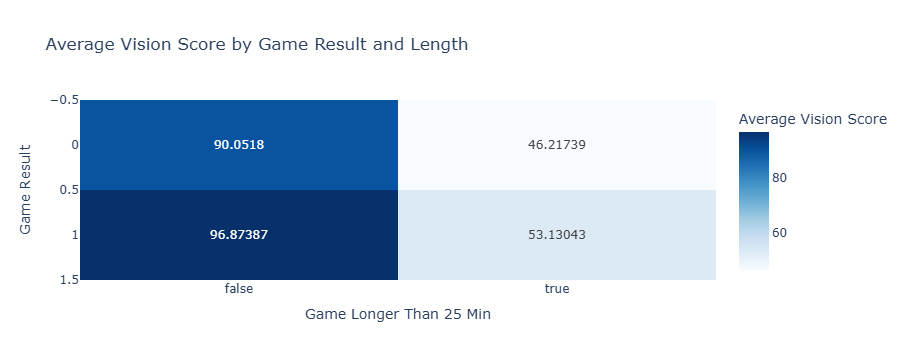

In [354]:
fig = px.imshow(pivot_table, text_auto=True, color_continuous_scale="Blues",
                labels=dict(x="Game Longer Than 25 Min", y="Game Result", color="Average Vision Score"),
                title="Average Vision Score by Game Result and Length")
fig.show()

fig.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_11.html', include_plotlyjs='cdn')


## Step 6: Baseline Model

Mean Squared Error (Baseline Model): 930.7280695435069


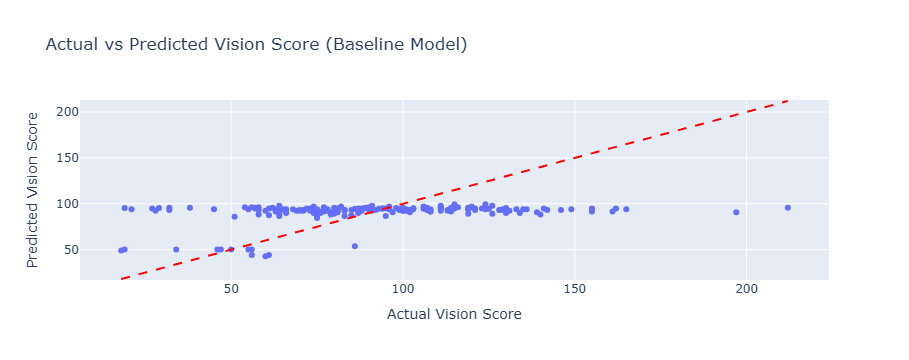

In [355]:
features = ["killsat25", "assistsat25", "is_25"] 
target = "visionscore"  

X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ["killsat25", "assistsat25"]
categorical_features = ["is_25"]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="mean")),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model = LinearRegression()
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Baseline Model): {mse}")

import plotly.express as px
fig = px.scatter(x=y_test, y=y_pred, 
                 labels={"x": "Actual Vision Score", "y": "Predicted Vision Score"},
                 title="Actual vs Predicted Vision Score (Baseline Model)")
fig.add_shape(type="line", x0=min(y_test), y0=min(y_test), x1=max(y_test), y1=max(y_test),
              line=dict(color="Red", dash="dash"))
fig.show()
fig.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_12.html', include_plotlyjs='cdn')


## Step 7: Final Model

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mean Squared Error (Final Model): 263.567804709028


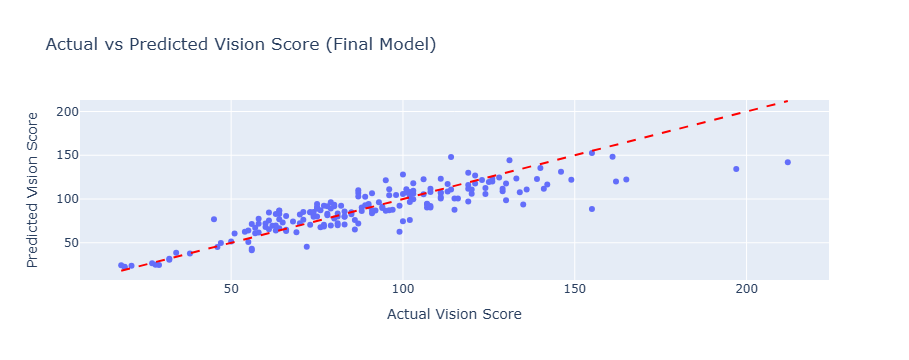

In [356]:
support_data['creep_score_per_minute'] = support_data['total cs'] / support_data['gamelength']
support_data['cumulative_kda_at_25'] = support_data['killsat25'] + support_data['assistsat25'] - support_data['deathsat25']

features = ['csat25', 'gamelength', 'killsat25', 'assistsat25', 'deathsat25', 'creep_score_per_minute', 'cumulative_kda_at_25', 'is_25']
target = 'visionscore'

X = support_data[features]
y = support_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['csat25', 'gamelength', 'killsat25', 'assistsat25', 'deathsat25', 'creep_score_per_minute', 'cumulative_kda_at_25']
categorical_features = ['is_25']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

model = RandomForestRegressor(random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 15, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Final Model): {mse}")

fig = px.scatter(x=y_test, y=y_pred, 
                 labels={"x": "Actual Vision Score", "y": "Predicted Vision Score"},
                 title="Actual vs Predicted Vision Score (Final Model)")
fig.add_shape(type="line", x0=min(y_test), y0=min(y_test), x1=max(y_test), y1=max(y_test),
              line=dict(color="Red", dash="dash"))
fig.show()
fig.write_html(r'C:\Users\DerDo\Desktop\dsc80-final\League-of-Legends-Data-Project\plots\plot_13.html', include_plotlyjs='cdn')


## Step 8: Fairness Analysis

In [341]:
group_X = support_data[support_data['result'] == 0]  
group_Y = support_data[support_data['result'] == 1]  

y_pred_X = best_model.predict(group_X[features])  
y_pred_Y = best_model.predict(group_Y[features]) 

mse_X = mean_squared_error(group_X[target], y_pred_X)
mse_Y = mean_squared_error(group_Y[target], y_pred_Y)

print(f"MSE for Losses: {mse_X}")
print(f"MSE for Wins: {mse_Y}")

def permutation_test(X, y, model, num_iterations=1000):
    observed_diff = np.abs(mean_squared_error(y[0], model.predict(X[0])) - 
                           mean_squared_error(y[1], model.predict(X[1])))

    permutation_diffs = []
    for _ in range(num_iterations):
        shuffled_y = np.random.permutation(y)
        diff = np.abs(mean_squared_error(shuffled_y[0], model.predict(X[0])) - 
                      mean_squared_error(shuffled_y[1], model.predict(X[1])))
        permutation_diffs.append(diff)

    p_value = np.mean(np.array(permutation_diffs) >= observed_diff)
    return p_value

p_value = permutation_test([group_X[features], group_Y[features]], [group_X[target], group_Y[target]], best_model)

print(f"P-value from Permutation Test: {p_value}")
if p_value < 0.05:
    print("There is a significant difference in MSE between the two groups (losses vs wins).")
else:
    print("There is no significant difference in MSE between the two groups (losses vs wins).")

MSE for Losses: 88.38438333872634
MSE for Wins: 121.27963552692151
P-value from Permutation Test: 1.0
There is no significant difference in MSE between the two groups (losses vs wins).
